# SST trends

This Jupyter notebook shows how to compute the SST trend maps reported in the manuscript "Global changes in oceanic mesoscale currents over the satellite altimetry record".

In [1]:
# Import libraries
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs

import pylab as plt
import numpy as np
# Inline plotting
%matplotlib inline

#### Import Mann Kendall test:

In [2]:
from xarrayMannKendall import Mann_Kendall_test

In [3]:
from utils import area,ccrs_land,add_patches
import datetime as datetime

In [4]:
from dask.distributed import Client

In [5]:
c = Client()
c

Client Scheduler: tcp://127.0.0.1:45155 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 36 Memory: 154.62 GB


In [6]:
dataset_SST = xr.open_dataset('../datasets/SST_timeseries.nc',chunks={'lat':10,'lon':10})

In [7]:
SST_timeseries = dataset_SST.SST

In [8]:
#.where(np.isfinite(dataset.EKE_eddy),0)
SST = SST_timeseries.sortby('time').sel(time=slice('1993','2020'))

In [9]:
SST

,Array,Chunk
Bytes,2.65 GB,4.09 MB
Shape,"(10227, 180, 360)","(10227, 10, 10)"
Count,1297 Tasks,648 Chunks
Type,float32,numpy.ndarray


In [10]:
# Print function used.
?Mann_Kendall_test

Init signature:
Mann_Kendall_test(
    DataArray,
    dim='time',
    alpha=0.01,
    MK_modified=False,
    method='linregress',
    coords_name=None,
)
Docstring:     
Compute linear trends and significance using Mann Kendall test.

Parameters
----------
DataArray : xarray.DataArray
    Dataset to analyse.
dim : str
    Coordiante name in which the linear trend will apply ('time').
alpha: float
    Significance level (default = 0.01)
MK_modified: Boolean
    Modified Mann-Kendall using Yue and Wang (2004) method.
    DOI: https://doi.org/10.1023/B:WARM.0000043140.61082.60
method: str
    Method for linear regresion: linregress (default) and theilslopes
coords_name: dict
    Coordinates name dict renames coordinates to 'lon','lat'. 
    Example:   
        coords_name={'xu_ocean':'lon','yu_ocean':'lat','t':time}
        
Example:

    # Time series length
    n=100
    time = np.arange(n)
    # Grid
    x = np.arange(4)
    y = np.arange(4)
    
    # Create dataarray
    data = np.ze

For more information in the Mann-Kendall method, please refer to: https://doi.org/10.1023/B:WARM.0000043140.61082.60

The reported trends use a modified Mann-Kendall method. A modified Mann-Kendall test is used to assess statistical significance of trends, while properly taking into account the autocorrelation in the time-series. The effective sample size for all the reported trends is always smaller than the actual sample size, due to autocorrelation of the time series. 

In [11]:
sst_trends = Mann_Kendall_test(SST,'time',MK_modified=True,
                               method="linregress",alpha=0.05, 
                               coords_name = {'time':'time','x':'lon','y':'lat'})

Note that the following cell will take ~1 hour depending on the number of cores, as the Mann-Kendall method requirest to invert a matrix of shape (len(time),len(time)) for each grid point.

In [12]:
sst_grad = sst_trends.compute()

In [13]:
sst_grad.attrs['title'] = "Sea Surface Temperature trends"
sst_grad.attrs['Description'] = """SST computed from OISST-NOAA. Then trends were computed using a modified Mann-Kendall test. \n See: https://github.com/josuemtzmo/xarrayMannKendall."""
sst_grad.attrs['Publication'] = "Dataset created for Martínez-Moreno, J. et. al. 2020: \n 'Mesoscale kinetic energy response to changing oceans'"
sst_grad.attrs['Author'] = "Josué Martínez-Moreno"
sst_grad.attrs['Contact'] = "josue.martinezmoreno@anu.edu.au"

sst_grad.attrs['Created date'] = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

######################################################

sst_grad['trend'].attrs['units'] = r"$^\circ C m^{-1} day^{-1}$"
sst_grad['trend'].attrs['name'] = 'trend'
sst_grad['trend'].attrs['long_name'] = "Sea Surface Temperature trends"

sst_grad['trend'].attrs['missing_value'] = np.nan
sst_grad['trend'].attrs['valid_min'] = np.nanmin(sst_grad['trend'])
sst_grad['trend'].attrs['valid_max'] = np.nanmax(sst_grad['trend'])
sst_grad['trend'].attrs['valid_range'] = [np.nanmin(sst_grad['trend']),np.nanmax(sst_grad['trend'])]

######################################################

sst_grad['signif'].attrs['units'] = ""
sst_grad['signif'].attrs['name'] = 'signif'
sst_grad['signif'].attrs['long_name'] = "Sea Surface Temperature trends significance"

sst_grad['signif'].attrs['missing_value'] = np.nan
sst_grad['signif'].attrs['valid_min'] = np.nanmin(sst_grad['signif'])
sst_grad['signif'].attrs['valid_max'] = np.nanmax(sst_grad['signif'])
sst_grad['signif'].attrs['valid_range'] = [np.nanmin(sst_grad['signif']),np.nanmax(sst_grad['signif'])]

######################################################

sst_grad['p'].attrs['units'] = ""
sst_grad['p'].attrs['name'] = 'p'
sst_grad['p'].attrs['long_name'] = "Sea Surface Temperature trends p"

sst_grad['p'].attrs['missing_value'] = np.nan
sst_grad['p'].attrs['valid_min'] = np.nanmin(sst_grad['p'])
sst_grad['p'].attrs['valid_max'] = np.nanmax(sst_grad['p'])
sst_grad['p'].attrs['valid_range'] = [np.nanmin(sst_grad['p']),np.nanmax(sst_grad['p'])]

In [14]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in sst_grad.data_vars}

sst_grad.to_netcdf('../datasets/SST_trends.nc', encoding=encoding)

In [15]:
trends = sst_grad.trend*10*365 # Convert to trends per decade

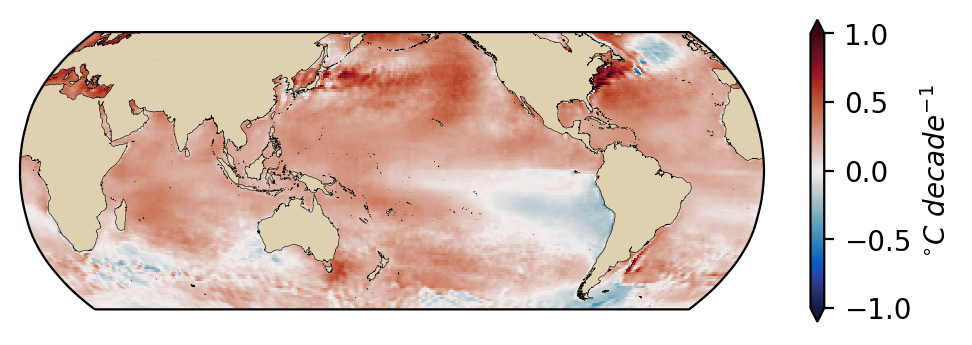

In [16]:
fig = plt.figure(figsize=(6,2), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude=180))

im = trends.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$^{\circ}C\ decade^{-1}$"),
              cmap=cm.cm.balance, vmin=-1, vmax=1,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
add_patches(ax)